# 11 Reprojecting

In this section we will:
- practice merging data frames
- apply `if-else` statements for flow control
- reproject geospatial data 
- create a choropleth map

## About the data

The first dataset we will use is a [list of Arctic communities and their location](https://search.dataone.org/view/doi%3A10.18739%2FA28S4JQ80) @brook_approximate_2023 created by the [Alaska Native Tribal Health Consortium](https://www.anthc.org). This data comess in GeoJSON file with the following attributes:

- **name**: name of Arctic community, 
- **population**: population of Arctic community, as of 2022
- **country**: country that the Arctic community falls within (see dataset metadata for the codes)
- **geoname-id**: numeric codes that uniquely identify all administrative/legal and statistical geographic areas for which the Census Bureau tabulates data

The second dataset is [Natural Earth's medium scale  cultural boundaries data for countries (1:50m)](https://www.naturalearthdata.com/downloads/50m-cultural-vectors/). 
We can obtain this dataset by downloading the shapefile. 
[Natural Earth](https://www.naturalearthdata.com) is a public domain dataset with ready-to-use data for creating maps. 

## Import data

We will first import the countries shapefile and adapt it for wrangling purposes:

**EXERCISE** 

The following code has 4 bugs, find them and correct them in order to udpate the data.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd

"""
Set environment variable 'PROJ_LIB' to specify the path for the PROJ library
Resolves ERROR 1: PROJ: proj_create_from_database
"""""
os.environ['PROJ_LIB'] = '/opt/anaconda3/share/proj'

# -------------------------------------------------------
# Import data

# Path to course data folder
data_folder_fp = os.path.join('/',
                              'courses',
                              'EDS220', 
                              'data')

# Import countries shapefile
fp = os.path.join(data_folder_fp, 
                  'ne_50m_admin_0_countries', 
                  'ne_50m_admin_0_countries.shp')

countries = gpd.read_file(fp)
countries.columns = countries.columns.str.lower()  # Simplify column names

# Import Arctic communities GeoJSON directly from URL
URL = 'https://cn.dataone.org/cn/v2/resolve/urn%3Auuid%3Aed7718ae-fb0d-43dd-9270-fbfe80bfc7a4'
communities = gpd.read_file(URL)

# Import country names CSV
fp = os.path.join(data_folder_fp, 
                  'country_names', 
                  'country_names.csv')
country_names = pd.read_csv(fp)

In [2]:
countries = countries[['admin', 'type', 'geometry']]
countries.head(3)

,admin,type,geometry
0,Zimbabwe,Sovereign country,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,Sovereign country,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."
2,Yemen,Sovereign country,"MULTIPOLYGON (((53.08564 16.64839, 52.58145 16..."


In [3]:
communities.head(3)

,name,population,country,geoname-id,geometry
0,Udomlya,32373,RU,452949,POINT (34.99250 57.87944)
1,Valmiera,26963,LV,453754,POINT (25.42751 57.54108)
2,Ventspils,42644,LV,454310,POINT (21.57288 57.38988)


In [4]:
country_names

,country,admin
0,RU,Russia
1,LV,Latvia
2,EE,Estonia
3,LT,Lithuania
4,SE,Sweden
5,BY,Belarus
6,FI,Finland
7,NO,Norway
8,DK,Denmark
9,FO,Faroe Islands


The CRS of the `communities` dataframe is EPSG:4326 = WGS 84. All GeoJSON files have that same CRS:

In [5]:
communities.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [6]:
countries.crs

<Geographic 2D CRS: GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84" ...>
Name: WGS 84
Axis Info [ellipsoidal]:
- lon[east]: Longitude (Degree)
- lat[north]: Latitude (Degree)
Area of Use:
- undefined
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

The `countries` geodataframe is actually also WGS 84 (EPSG:4326), but internally they are represented slightly differently and this may cause confusion.

In [7]:
countries.crs == communities.crs

False

To be on the safe side, we will reproject to make sure both datasets have the same CRS.

**Reprojecting** means changing coordinate reference systems of your geospatial data.

Changing CRSs in geopandas is super easy using the following:
```python
updated_geodf = geodf.to_crs(new_crs)
```
where:

- `updated_gdf` = the output of the method, geodf with the updated CRS (reprojected)
- `geodf` = the geodf that we want to reproject
- `new_crs` = the CRS we want to conver to, can be a CRS object or a string representing a CRS.

In [8]:
# Reprojecting countries to ensure CRS consistency
countries = countries.to_crs(communities.crs)

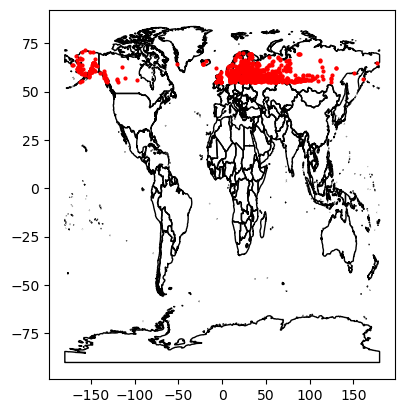

In [23]:
# Plot geospatial data
assert countries.crs == communities.crs

fig, ax = plt.subplots()
countries.plot(ax = ax,
              color = 'none')
communities.plot(ax = ax,
                color = "red",
                markersize = 4)
plt.show()

## Arctic communities by country

In [28]:
# Create a dataframe with the number of communities per country
n_comms = (communities.groupby('country')
                    .size()
                    .reset_index(name = "n_communities"))

Our goal is to merge the `n_comms` and the `countries` data frame to create a chorpleth map.

**To merge two data frames, they need to have one column in common.**

Currently our datasets do not have any columns in common:

In [29]:
countries.columns

Index(['admin', 'type', 'geometry'], dtype='object')

In [31]:
n_comms.columns

Index(['country', 'n_communities'], dtype='object')

In [33]:
# Find the intersection between countries cols and n_comms cols
set(countries.columns).intersection(n_comms.columns)

set()

## Merge the data

We can use the `country_names` data frame to add the names countries into the `n_comms` data which, in turn, will allow us to merge that data frame with 

In [34]:
n_comms.head(2)

,country,n_communities
0,AX,1
1,BY,8


In [35]:
countries.head(2)

,admin,type,geometry
0,Zimbabwe,Sovereign country,"POLYGON ((31.28789 -22.40205, 31.19727 -22.344..."
1,Zambia,Sovereign country,"POLYGON ((30.39609 -15.64307, 30.25068 -15.643..."


In [36]:
country_names.head(2)

,country,admin
0,RU,Russia
1,LV,Latvia


To merge:

```python
output_df = pd.merge(left_df,
                    right_df,
                    how = type_of_join,
                    on = column_to_join)
```

where:
- `output_df` = df resulting from the merge
- `left_df` = df on the "left" side
- `right_df` = df on the "right" side
- `how` = type of join: inner, left, right, ...
- `on` = column to join on, must be present on both dfs

In [37]:
n_comms = pd.merge(n_comms,
                  country_names,
                  how = 'left',
                  on = 'country')
n_comms

,country,n_communities,admin
0,AX,1,Aland Islands
1,BY,8,Belarus
2,CA,7,Canada
3,DK,72,Denmark
4,EE,14,Estonia
5,FI,98,Finland
6,FO,1,Faroe Islands
7,GB,96,United Kingdom
8,GL,1,Greenland
9,IS,5,Iceland


In [38]:
# Merge the data frames
arctic_countries = pd.merge(countries, 
                            n_comms, 
                            how = 'inner',
                            on = 'admin')
arctic_countries.head(5)

,admin,type,geometry,country,n_communities
0,United States of America,Country,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576...",US,115
1,United Kingdom,Country,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51...",GB,96
2,Sweden,Sovereign country,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57...",SE,133


When doing the inner join, we drop the Aland Islands from the `n_comms` dataset

In [43]:
# Check Aland Islands is nowhere in the countries dataframe
'Aland Islands' in countries.values

False

In [44]:
arctic_countries = arctic_countries.set_index('admin')
arctic_countries.head(3)

,type,geometry,country,n_communities
admin,,,,
United States of America,Country,"MULTIPOLYGON (((-132.74687 56.52568, -132.7576...",US,115
United Kingdom,Country,"MULTIPOLYGON (((-2.66768 51.62300, -2.74214 51...",GB,96
Sweden,Sovereign country,"MULTIPOLYGON (((19.07646 57.83594, 18.99375 57...",SE,133


In [45]:
arctic_countries.at['Finland', 'n_communities'] += 1

## Choropleth map

<Axes: >

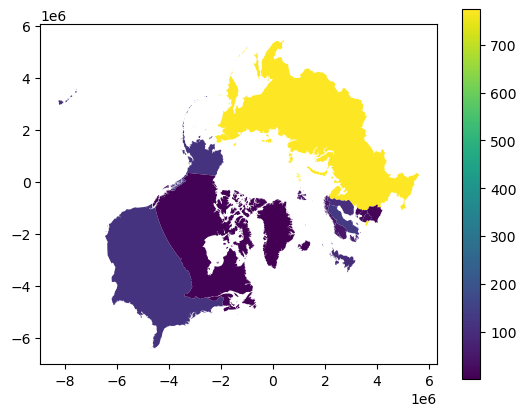

In [49]:
arctic_countries.plot(column = "n_communities",
                     legend = True)

In [48]:
# Reproject to CRS optimized for the Arctic region
arctic_countries = arctic_countries.to_crs('epsg:3413')